In [1]:
using Plots, SparseArrays, LinearAlgebra, IterativeSolvers

include("geometricMultiGrid.jl")
include("constructions1D.jl")
include("constructions2D.jl")

pointsource_half2D (generic function with 1 method)

In [99]:
struct myPreconditioner
    precon::Function
end

function LinearAlgebra.ldiv!(y, P::myPreconditioner, x)
    y .= P.precon(x)
    return y
end

function LinearAlgebra.ldiv!(P::myPreconditioner, x)
    x .= P.precon(x)
    return x
end

# Define \ for VcyclePreconditioner
function LinearAlgebra.:\(P::myPreconditioner, x)
    return P.pre_con(x)
end

function preconditioner(n, sigma,f)
    helmholtz2D_sigma(x) = helmholtz2D(x, sigma)
    wjacobi_omega(A, f, u) = wjacobi(A, f, u, 2 / 3)
    pres(x) = real(geoVcycle(
                mat = helmholtz2D_sigma,
                f = f,
                u = x,
                nu1 = 1,
                nu2 = 1,
                relax = wjacobi_omega,
                restrict = simple_restrict2D,
                interpolate = simple_interpolate2D,
                recursion_depth = 100,
                dimensions = 2
            ))

    return myPreconditioner(pres)
end

preconditioner (generic function with 2 methods)

In [78]:
n = 128
f = float(pointsource_half2D(n)) 
solutions = []
histories = []
preconditioner_values = [-600-300im,-600-600im,  -600-2000im, -600-10^4im]

sol, history = gmres(helmholtz2D(n, -600), f , log=true,maxiter = 500,restart=500)
push!(solutions, sol)
push!(histories, history)
for value in preconditioner_values
    sol, history = gmres(helmholtz2D(n, -600), f, Pl=preconditioner(n, value,f), log=true,maxiter = 500,restart=500)
    push!(solutions, sol)
    push!(histories, history)
end

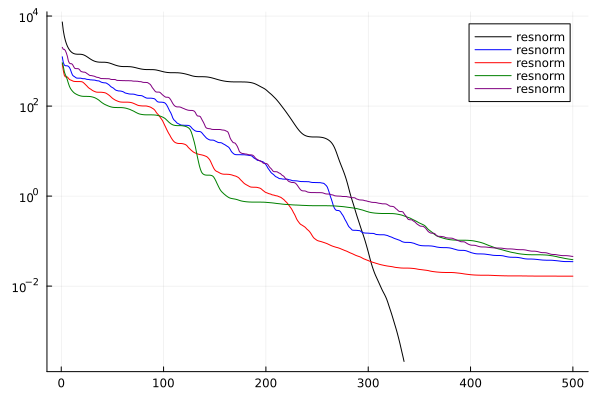

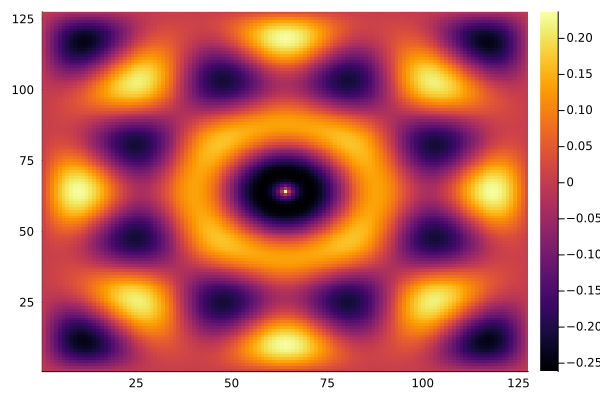

In [79]:
colors = [:black,:blue, :red, :green,:purple]
p = plot(yscale=:log10, legend=true) # Set up the plot

for i in 1:length(histories)
    plot!(p,histories[i], linecolor=colors[i],label="lol")
end
display(p)
heatmap(reshape(solutions[1], n - 1, n - 1))

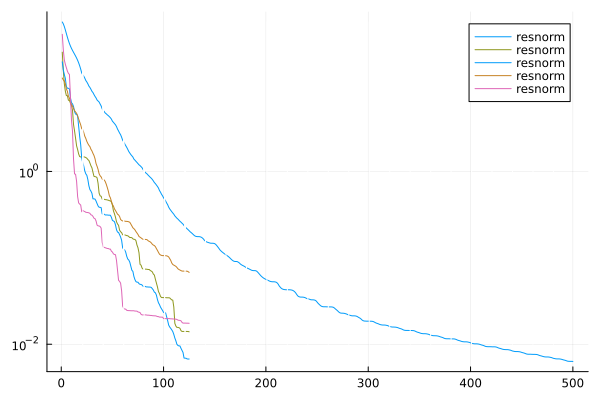

In [113]:
n = 64
restarts = 20
f = wave_basis_2D(n,6,6) + wave_basis_2Dx(n,8) 
preconditioner_values = [-600-300im,-600-600im,  -600-2000im, -600-10^4im]

p = plot(yscale=:log10, legend=true) # Set up the plot
sol, history = gmres(helmholtz2D(n, -600), f , log=true,maxiter = 500,restart=restarts)
    plot!(p,history)

for value in preconditioner_values
    sol, history = gmres(helmholtz2D(n, -600), f, Pl=preconditioner(n, value,f), log=true,maxiter = 125,restart=restarts)
    plot!(p,history)
end

display(p)

In [12]:
n = 128
@profile sol, history = gmres(helmholtz2D(n, -600), float(pointsource_half2D(n)), Pl=preconditioner(n, -600-600im), log=true,maxiter = 500,restart=500)

([-0.004656857063805226, -0.00910017473839175, -0.0135370820355025, -0.017582116291849727, -0.021489160380279804, -0.024784887506348278, -0.027873321690305142, -0.03026938193826611, -0.03232420436464948, -0.03380177826285143  …  -0.03380178646028703, -0.03232421172805677, -0.030269388467363132, -0.027873327382224793, -0.024784892362532757, -0.021489164408783356, -0.01758211949935055, -0.01353708443340405, -0.009100176332875186, -0.004656857859910888], Not converged after 500 iterations.)

In [13]:
pprof()

"profile.pb.gz"